- separate LXP 69.5 color investigation from that of other source
- get rid of duplicate I band points

In [2]:
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline

# 1. Load in V and I band OGLE Data for LXP 69.5

In [3]:
lv = np.loadtxt('lmc519.22.v.25564.dat',usecols=range(0,3))
lv = pd.DataFrame(lv,columns=['MJD-50000','V mag','V mag err'])

In [5]:
li = np.loadtxt('phot.dat',usecols=range(0,3))
li = pd.DataFrame(li,columns=['JD','I mag','I mag err'])
li['MJD-50000']=li['JD']-2450000.5
li['I mag']=li['I mag']+.041 #calibrated I mag
#get rid of duplicates
li = li.drop_duplicates(subset=['MJD-50000'], keep='last')
#making sure it is sorted by time
li = li.sort_values(by='MJD-50000')

In [7]:
#since duplicates dropped, need to redo indexing
li['ind'] = np.arange(len(li))
li = li.set_index('ind')

In [9]:
def sf(filename,path='VIFigs/'):
    '''
    Saves figure in OglePeriods/VIFigs/
    '''
    plt.savefig(path+filename+'.png',dpi=200,bbox_inches='tight')

# 2. Plot Lightcurves in Each Filter

Text(0, 0.5, 'OGLE V magnitude')

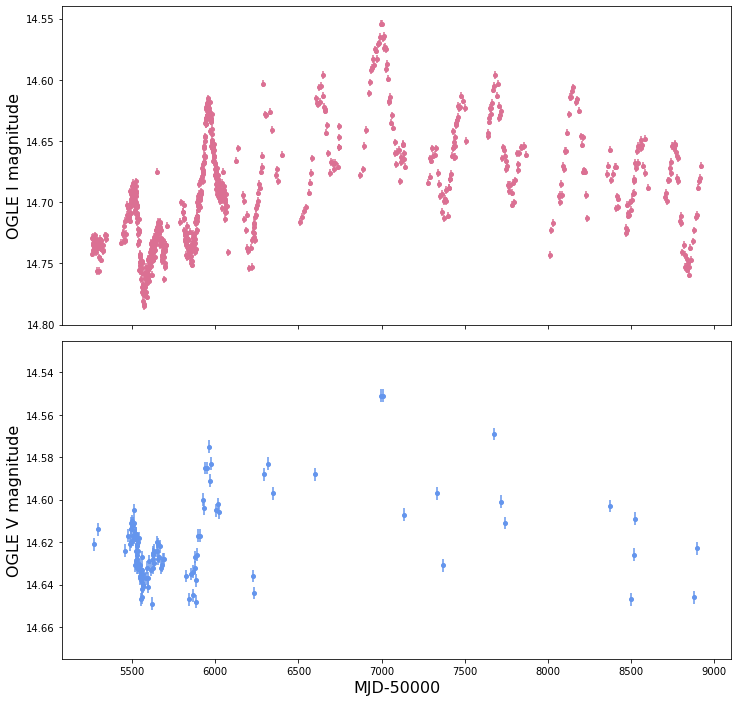

In [10]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,12))
plt.subplots_adjust(hspace=0.05)
ax[0].errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,linestyle='None',color='palevioletred')
ax[0].set_ylim(14.8,14.54)
ax[1].set_xlabel('MJD-50000',fontsize=16)
ax[0].set_ylabel('OGLE I magnitude',fontsize=16)
ax[1].errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,linestyle='None',color='cornflowerblue')
ax[1].set_ylim(14.675,14.525)
ax[1].set_ylabel('OGLE V magnitude',fontsize=16)

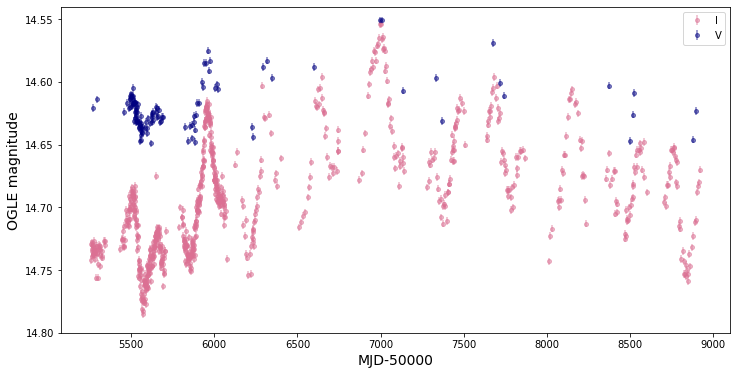

In [11]:
plt.figure(figsize=(12,6))
plt.errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='palevioletred',label='I')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE magnitude',fontsize=14)
plt.errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='navy',label='V')
plt.ylim(14.8,14.54)
#plt.tick_params(labelsize=14)
plt.legend()
#sf('VIoneplot')

Text(0, 0.5, 'OGLE I mag')

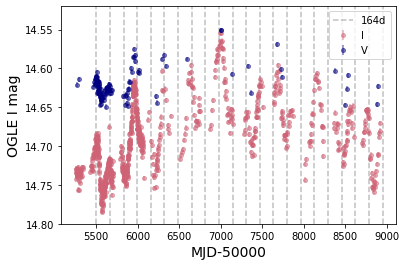

In [52]:
plt.errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='#CF6275',label='I')
plt.errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='navy',label='V')
plt.ylim(14.8,14.52)
for i in range(1,22):
     plt.axvline(5503+i*164,0,1,linestyle='dashed',color='grey',alpha=.5)
plt.axvline(5503,0,1,linestyle='dashed',color='grey',alpha=.5,label='164d')
plt.legend(loc='upper right')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#sf('VI86')

# 3. Linearly Interpolate Between I band Values and Investigate V-I Color
interpolate at time values from V mag observations

In [12]:
l_interp = np.interp(lv['MJD-50000'],li['MJD-50000'],li['I mag'])


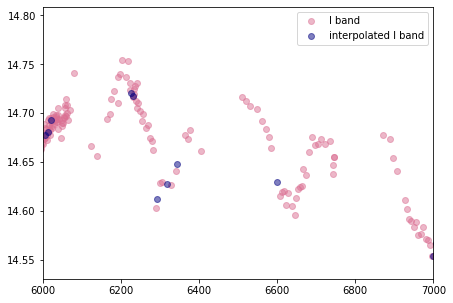

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(li['MJD-50000'], li['I mag'],color='palevioletred',alpha=.5,label='I band')
plt.scatter(lv['MJD-50000'],l_interp,alpha=.5,color='navy',label='interpolated I band')
#plt.ylim(15.6,14.8)
plt.xlim(6000,7000)
plt.legend()
#sf('interpex')

In [16]:
li['I mag err'].describe()


count    7.790000e+02
mean     3.000000e-03
std      2.907529e-17
min      3.000000e-03
25%      3.000000e-03
50%      3.000000e-03
75%      3.000000e-03
max      3.000000e-03
Name: I mag err, dtype: float64

### for now, errors for interpolated I band values are double their usual value
2*.003 = .006 magnitudes

In [17]:
ie = np.ones(len(l_interp))
ie = ie*.006

In [18]:
verr = unumpy.uarray(lv['V mag'],lv['V mag err'])
ierr = unumpy.uarray(l_interp,ie)
v_i = verr-ierr
v_i_err = unumpy.std_devs(v_i)


(14.66, 14.54)

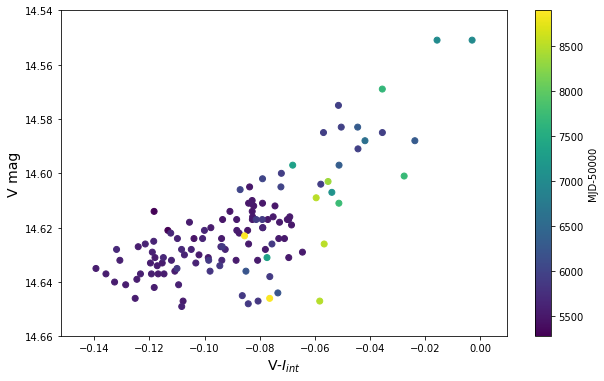

In [20]:
#plot V-I color, no error for now
plt.figure(figsize=(10,6))
plt.scatter(lv['V mag']-l_interp,lv['V mag'],c=lv['MJD-50000'])
plt.colorbar(label='MJD-50000')
plt.ylabel('V mag',fontsize=14)
plt.xlabel('V-$I_{int}$',fontsize=14) #redder when brighter, besides during flares?
plt.ylim(14.66,14.54)
#sf('colormagcm')

(14.66, 14.54)

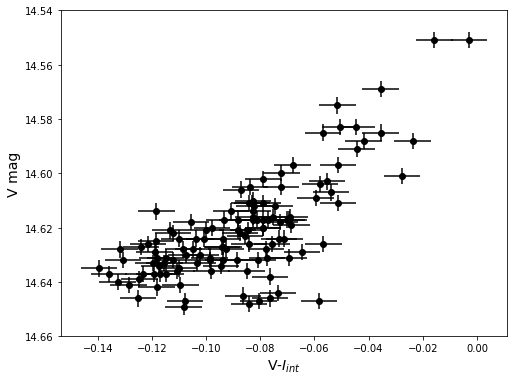

In [22]:
#plot V-I color, no error for now
plt.figure(figsize=(8,6))
plt.errorbar(lv['V mag']-l_interp,lv['V mag'],yerr=lv['V mag err'],xerr=v_i_err,color='black',linestyle='none',marker='o')
#plt.colorbar()
plt.ylabel('V mag',fontsize=14)
plt.xlabel('V-$I_{int}$',fontsize=14) #redder when brighter, besides during flares?
plt.ylim(14.66,14.54)
#plt.text(14.545,0.01,'red and bright')
#plt.savefig('color-mag2.png',dpi=200,bbox_inches='tight')
#sf('colormag')

In [34]:
#add phase columns
lv['Phase 164'] = lv['MJD-50000'] % 164
lv['Phase 155'] = lv['MJD-50000'] % 155
lv['Phase 150'] = lv['MJD-50000'] % 150
li['Phase 150'] = li['MJD-50000'] % 150


Text(0, 0.5, 'OGLE V-I')

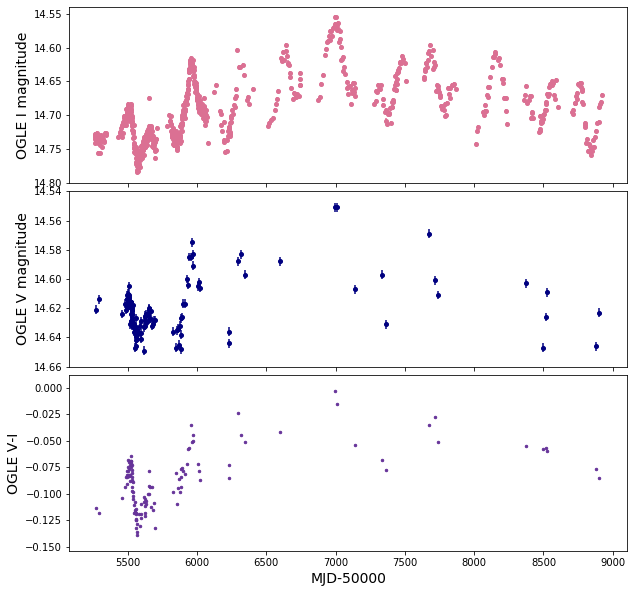

In [24]:
#plot V, I, and V-I vs. time
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
plt.subplots_adjust(hspace=0.05)
ax[0].errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,linestyle='None',color='palevioletred')
ax[0].set_ylim(14.8,14.54)
ax[2].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('OGLE I magnitude',fontsize=14)
ax[1].errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,linestyle='None',color='navy')
ax[1].set_ylim(14.66,14.54)
ax[2].scatter(lv['MJD-50000'],lv['V mag']-l_interp,s=6,color='rebeccapurple')
ax[1].set_ylabel('OGLE V magnitude',fontsize=14)
ax[2].set_ylabel('OGLE V-I',fontsize=14)
#sf('VIV-I')

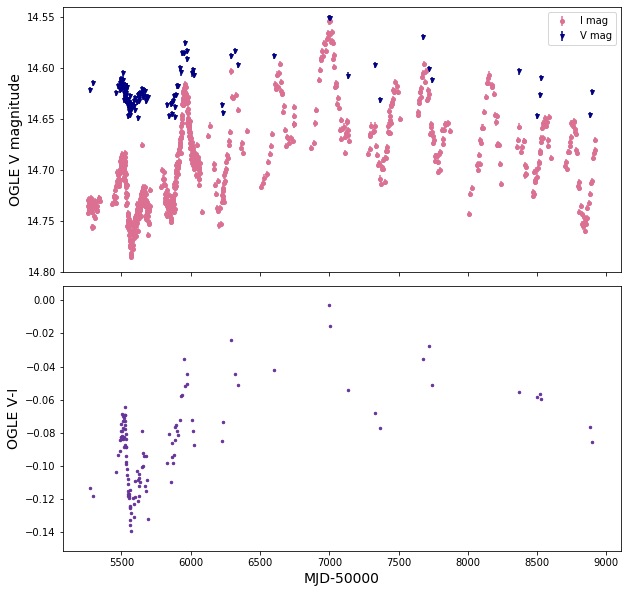

In [25]:
#plot V, I, and V-I vs. time
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
plt.subplots_adjust(hspace=0.05)
ax[0].errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,linestyle='None',color='palevioletred',label='I mag')
ax[0].set_ylim(14.8,14.54)
ax[1].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('OGLE I magnitude',fontsize=14)
ax[0].errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='v',markersize=4,linestyle='None',color='navy',label='V mag')
ax[1].scatter(lv['MJD-50000'],lv['V mag']-l_interp,s=6,color='rebeccapurple')
ax[0].set_ylabel('OGLE V magnitude',fontsize=14)
ax[1].set_ylabel('OGLE V-I',fontsize=14)
ax[0].legend()

(5200, 6500)

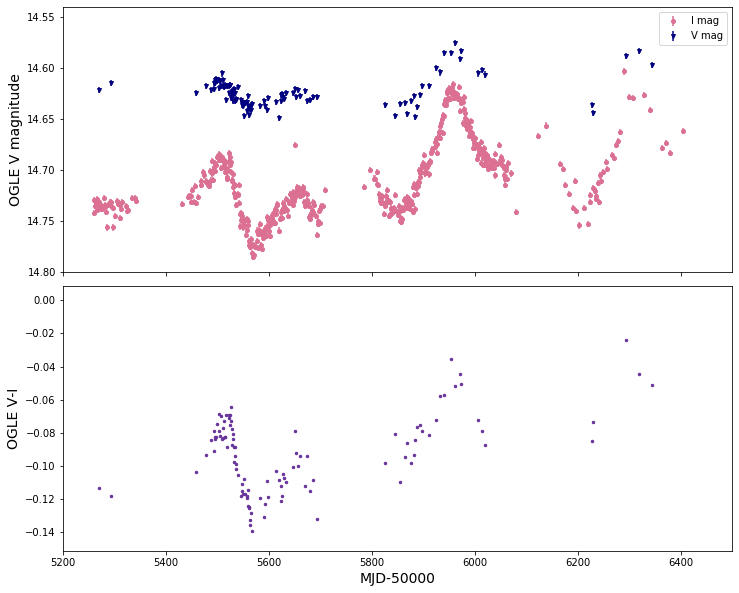

In [26]:
#plot V, I, and V-I vs. time
fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,10))
plt.subplots_adjust(hspace=0.05)
ax[0].errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,linestyle='None',color='palevioletred',label='I mag')
ax[0].set_ylim(14.8,14.54)
ax[1].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('OGLE I magnitude',fontsize=14)
ax[0].errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='v',markersize=4,linestyle='None',color='navy',label='V mag')
ax[1].scatter(lv['MJD-50000'],lv['V mag']-l_interp,s=6,color='rebeccapurple')
ax[0].set_ylabel('OGLE V magnitude',fontsize=14)
ax[1].set_ylabel('OGLE V-I',fontsize=14)
ax[0].legend()
#ax[1].set_ylim(-.11,.02)
plt.xlim(5200,6500)
#sf('firstthreeVI')

# 4. Look at Relative Variability
quanitfy higher variability in I band

In [31]:
print('V mag median minus min: ',np.abs(lv['V mag'].min()-np.median(lv['V mag'])))
print('V mag max minus median: ',lv['V mag'].max()-np.median(lv['V mag']))
print('V mag max minus min: ',lv['V mag'].max()-np.min(lv['V mag']))
print('V mag standard deviation: ',np.std(lv['V mag']))

V mag median minus min:  0.0730000000000004
V mag max minus median:  0.02499999999999858
V mag max minus min:  0.09799999999999898
V mag standard deviation:  0.01852888875778726


In [29]:
print('I mag median minus min: ',np.abs(li['I mag'].min()-np.median(li['I mag'])))
print('I mag max minus median: ',li['I mag'].max()-np.median(li['I mag']))
print('I mag max minus min: ',li['I mag'].max()-np.min(li['I mag']))
print('I mag standard deviation: ',np.std(li['I mag']))

I mag median minus min:  0.14300000000000068
I mag max minus median:  0.08799999999999919
I mag max minus min:  0.23099999999999987
I mag standard deviation:  0.045557358205206774


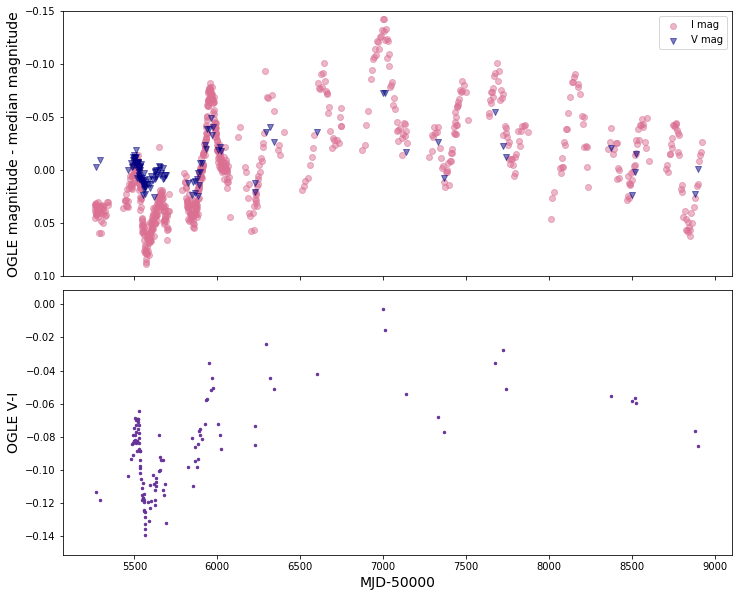

In [32]:
#deviation from respective median
fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,10))
plt.subplots_adjust(hspace=0.05)
ax[0].scatter(li['MJD-50000'],li['I mag']-np.median(li['I mag']),marker='o',alpha=.5,color='palevioletred',label='I mag')
ax[0].set_ylim(.1,-.15)
ax[1].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('OGLE magnitude',fontsize=14)
ax[0].scatter(lv['MJD-50000'],lv['V mag']-np.median(lv['V mag']),marker='v',color='navy',alpha=.5,label='V mag')
ax[1].scatter(lv['MJD-50000'],lv['V mag']-l_interp,s=6,color='rebeccapurple')
ax[0].set_ylabel('OGLE magnitude - median magnitude',fontsize=14)
ax[1].set_ylabel('OGLE V-I',fontsize=14)
ax[0].legend()
#ax[1].set_ylim(-.11,.02)
#plt.xlim(5200,6500)
#ax[0].set_title('Deviation from Median')
#sf('devmed')

# 5. Phase-Folding 

In [39]:
li['Phase 164'] = li['MJD-50000']%164
lv['Phase 153'] = (lv['MJD-50000']%153)/153
li['Phase 153'] = (li['MJD-50000']%153)/153
li['Phase 6467'] = (li['MJD-50000']%6467)/6467
lv['Phase 6467'] = (lv['MJD-50000']%6467)/6467
lv['Phase 3800'] = (lv['MJD-50000']%3800)/3800
li['Phase 3800'] = (li['MJD-50000']%3800)/3800

(14.66, 14.54)

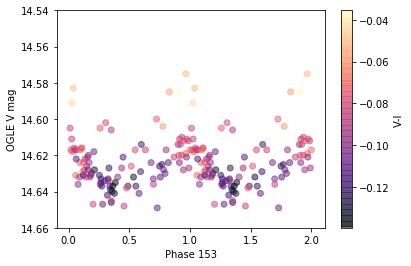

In [42]:
plt.scatter(lv['Phase 153'][:-19],lv['V mag'][:-19],c=lv['V mag'][:-19]-l_interp[:-19],alpha=.5,cmap='magma')
plt.scatter(1+lv['Phase 153'][:-19],lv['V mag'][:-19],c=lv['V mag'][:-19]-l_interp[:-19],alpha=.5,cmap='magma')
plt.colorbar(label='V-I')
plt.xlabel('Phase 153')
plt.ylabel('OGLE V mag')
plt.ylim(14.66,14.54)
#plt.scatter(li['Phase 164'],li['I mag'],color='palevioletred',alpha=.5)
#sf('phase153')

Text(0.5, 0, 'Phase (153 d)')

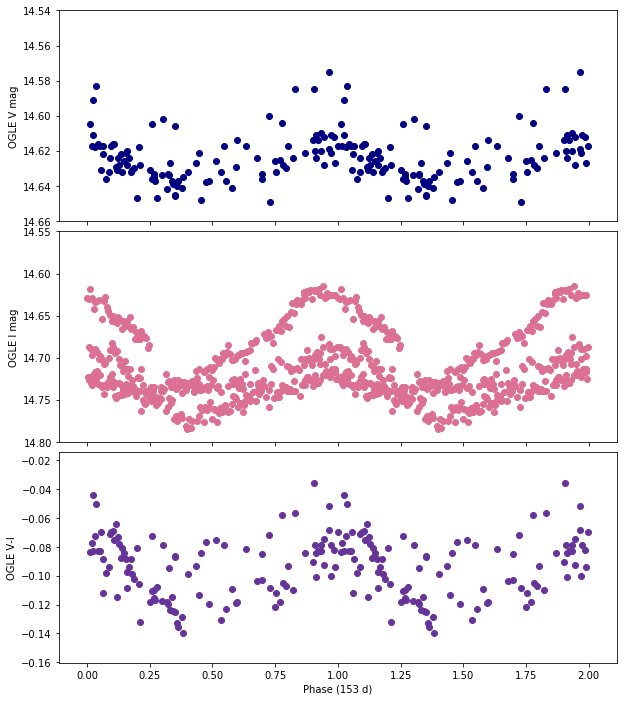

In [43]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,12))
plt.subplots_adjust(hspace=0.05)
ax[0].scatter(lv['Phase 153'][:-19],lv['V mag'][:-19],color='navy')
ax[0].scatter(1+lv['Phase 153'][:-19],lv['V mag'][:-19],color='navy')
ax[1].scatter(li['Phase 153'][:420],li['I mag'][:420],color='palevioletred')
ax[1].scatter(1+li['Phase 153'][:420],li['I mag'][:420],color='palevioletred')
#V-I
ax[2].scatter(lv['Phase 153'][:-19],lv['V mag'][:-19]-l_interp[:-19],color='rebeccapurple')
ax[2].scatter(1+lv['Phase 153'][:-19],lv['V mag'][:-19]-l_interp[:-19],color='rebeccapurple')
ax[2].set_ylabel('OGLE V-I')

ax[0].set_ylim(14.66,14.54)
ax[1].set_ylim(14.8,14.55)
plt.xlabel('Phase')
ax[0].set_ylabel('OGLE V mag')
ax[1].set_ylabel('OGLE I mag')
ax[2].set_xlabel('Phase (153 d)')
#sf('3magphase')

# 6. Final Color-Mag Figs

Text(0, 0.5, 'OGLE I mag')

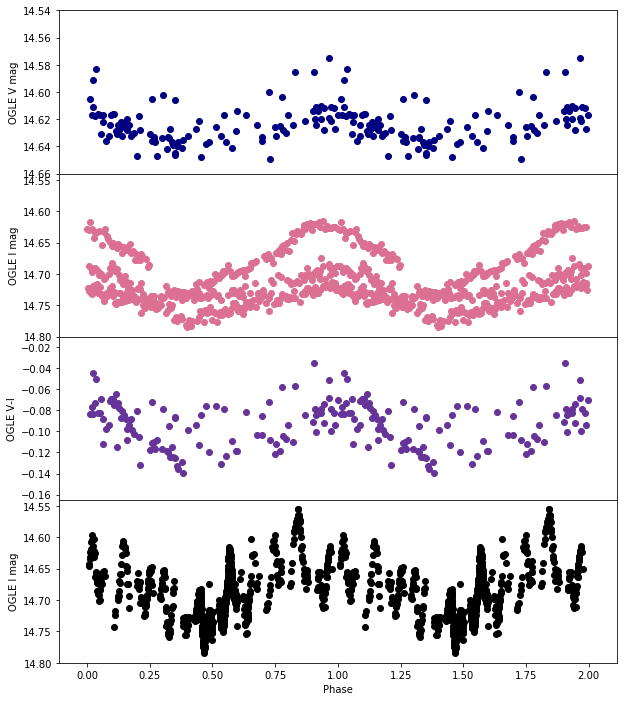

In [44]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,12))
plt.subplots_adjust(hspace=0)
ax[0].scatter(lv['Phase 153'][:-19],lv['V mag'][:-19],color='navy')
ax[0].scatter(1+lv['Phase 153'][:-19],lv['V mag'][:-19],color='navy')
ax[1].scatter(li['Phase 153'][:420],li['I mag'][:420],color='palevioletred')
ax[1].scatter(1+li['Phase 153'][:420],li['I mag'][:420],color='palevioletred')
#V-I
ax[2].scatter(lv['Phase 153'][:-19],lv['V mag'][:-19]-l_interp[:-19],color='rebeccapurple')
ax[2].scatter(1+lv['Phase 153'][:-19],lv['V mag'][:-19]-l_interp[:-19],color='rebeccapurple')
ax[2].set_ylabel('OGLE V-I')

ax[3].scatter(li['Phase 3800'],li['I mag'],color='black')
ax[3].scatter(1+li['Phase 3800'],li['I mag'],color='black')
ax[3].set_ylim(14.8,14.54)
ax[0].set_ylim(14.66,14.54)
ax[1].set_ylim(14.8,14.54)
plt.xlabel('Phase')
ax[0].set_ylabel('OGLE V mag')
ax[1].set_ylabel('OGLE I mag')
ax[3].set_ylabel('OGLE I mag')
# ax[0].text(0,14.56,'period = 153 d')
# ax[1].text(0,14.575,'period = 153 d')
# ax[2].text(0,0,'period = 153 d')
# #plt.ylim(14.66,14.54)
# ax[3].text(0,14.75,'period = 3800 d')

In [45]:
model = np.polyfit(lv['V mag'],l_interp, 1)


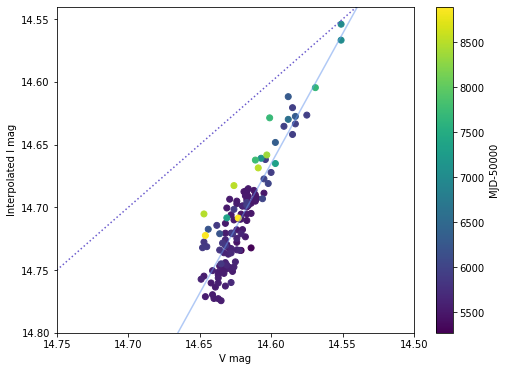

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(lv['V mag'],l_interp,c=lv['MJD-50000'])
plt.colorbar(label='MJD-50000')
plt.xlim(14.75,14.5)
plt.ylim(14.8,14.54)
plt.xlabel('V mag')
plt.ylabel('Interpolated I mag')
x = np.linspace(14.75,14.5)
plt.plot(x,x,color='slateblue',linestyle='dotted')

#plt.plot(x,x+.1)
plt.plot(x,model[0]*x+model[1],alpha=.5,color='cornflowerblue')
#plt.plot(x,model2[0]*x+model2[1],alpha=.5,color='cornflowerblue')

In [47]:
np.corrcoef(lv['V mag'],l_interp)


array([[1.        , 0.90502556],
       [0.90502556, 1.        ]])

Text(0, 0.5, 'Interpolated I mag')

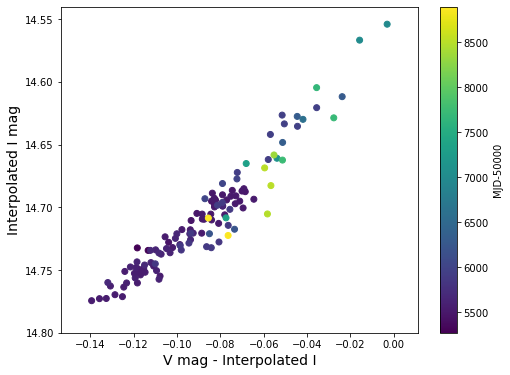

In [48]:
#just color-mag but with I instead of V
plt.figure(figsize=(8,6))
plt.scatter(lv['V mag']-l_interp,l_interp,c=lv['MJD-50000'])
plt.colorbar(label='MJD-50000')
#plt.xlim(14.75,14.5)
plt.ylim(14.8,14.54)
plt.xlabel('V mag - Interpolated I',fontsize=14)
plt.ylabel('Interpolated I mag',fontsize=14)
#x = np.linspace(14.75,14.5)
#plt.plot(x,x,color='slateblue',linestyle='dotted')

#plt.plot(x,x+.1)
#plt.plot(x,model[0]*x+model[1],alpha=.5,color='cornflowerblue')
#sf('interpcolormag')


Text(0.5, 0, 'Interpolated I mag')

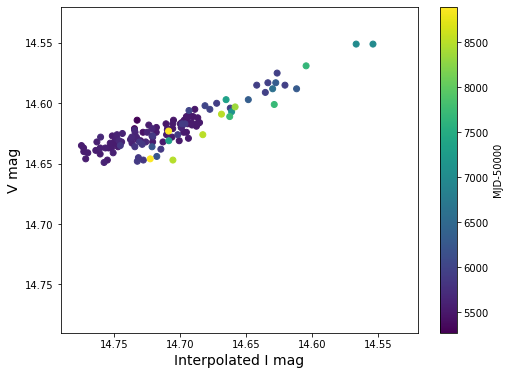

In [49]:
#follow-up: V vs. I_int
plt.figure(figsize=(8,6))
plt.scatter(l_interp,lv['V mag'],c=lv['MJD-50000'])
plt.colorbar(label='MJD-50000')
plt.xlim(14.79,14.52)
plt.ylim(14.79,14.52)
#plt.ylim(14.66,14.54)
plt.ylabel('V mag',fontsize=14)
plt.xlabel('Interpolated I mag',fontsize=14)
#sf('VI_int')

In [50]:
ivmod = np.polyfit(lv['V mag'],l_interp, 1)
ivmod

array([  2.0680136 , -15.52793386])

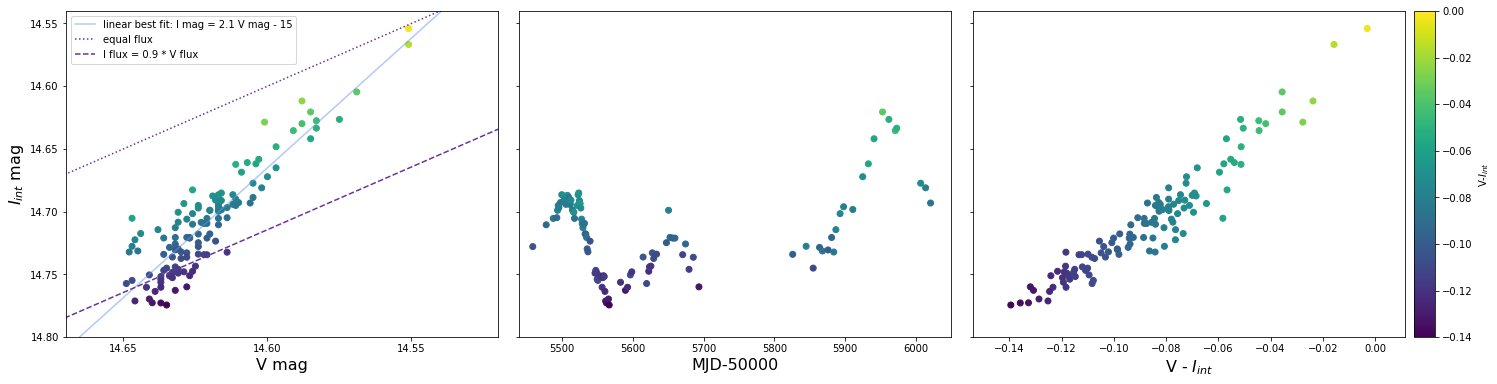

In [51]:
#three figures: I vs. V; V vs. time with V-I colorbar for limits above; I vs. V-I
fig,ax=plt.subplots(1,3,figsize=(24,6),sharey=True)
plt.subplots_adjust(wspace=.05)
#ax[1].scatter(lv['MJD-50000'][2:79],l_interp[2:79],c=lv['V mag'][2:79]-l_interp[2:79],vmin=-.14,vmax=0)
ax[1].scatter(lv['MJD-50000'],l_interp,c=lv['V mag']-l_interp,vmin=-.14,vmax=0)
ax[1].set_xlim(5440,6050)
ax[1].set_xlabel('MJD-50000',fontsize=16)
ax[0].set_ylabel('$I_{int}$ mag',fontsize=16)
#ax[1].set_ylim(14.78,14.68)
vlin = np.linspace(14.8,14.5)
ax[0].plot(vlin,ivmod[0]*vlin+ivmod[1],alpha=.5,color='cornflowerblue',label='linear best fit: I mag = 2.1 V mag - 15')
ax[0].plot(vlin,vlin,color='rebeccapurple',linestyle='dotted',label='equal flux')
ax[0].plot(vlin,vlin-2.5*np.log10(.9),color='rebeccapurple',linestyle='dashed',label='I flux = 0.9 * V flux')

ax[0].legend()
im=ax[0].scatter(lv['V mag'],l_interp,c=lv['V mag']-l_interp,vmin=-.14,vmax=0)
ax[0].set(xlim=(14.67,14.52),ylim=(14.8,14.54),xticks=[14.8,14.75,14.7,14.65,14.6,14.55])
ax[0].set_xlabel('V mag',fontsize=16)
ax[2].set_xlabel('V - $I_{int}$',fontsize=16)
ax[2].scatter(lv['V mag']-l_interp,l_interp,c=lv['V mag']-l_interp,vmin=-.14,vmax=0)
ax[2].set_ylim(14.8,14.54)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax[2],
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=ax[2].transAxes,
                   borderpad=0
                   )
#ax[0].text(14.53,14.67,'V-I',rotation=90,fontsize=14)
fig.colorbar(im,cax=axins,orientation='vertical',label='V-$I_{int}$',pad=.01)
#ax[2].yaxis.set_tick_params(labelleft=True)
#sf('threepanel')